In [1]:
import cv2               as cv
import urllib
import numpy             as np
import pandas            as pd
import seaborn           as sns
import random
import os
import glob
import shutil
from imutils        import paths
import matplotlib.pyplot as plt
from sklearn.utils  import shuffle
from urllib.request import urlopen
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models              import Sequential
from tensorflow.keras.preprocessing       import image
from tensorflow.keras.utils               import to_categorical
from tensorflow.keras.callbacks           import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers              import Conv2D,Flatten,MaxPooling2D,Dense,Dropout,SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img,array_to_img

## 1-) Data Preparation

Data Preprocessing + Data Augmentation

In [10]:
folder_path = "Dataset\Dataset_nonsplit"

In [3]:
#import os
#import shutil
#from sklearn.model_selection import train_test_split
##
##Folders
#original_dataset_folder = "Dataset\Dataset_nonsplit"
#base_folder = 'Dataset/Dataset_Split'
#os.makedirs(base_folder, exist_ok=True)
##Create Folders
#train_folder = os.path.join(base_folder, 'train')
#os.makedirs(train_folder, exist_ok=True)
#test_folder = os.path.join(base_folder, 'test')
#os.makedirs(test_folder, exist_ok=True)
##Create Class folders
#classes = os.listdir(original_dataset_folder)
#for class_ in classes:
#    os.makedirs(os.path.join(train_folder, class_), exist_ok=True)
#    os.makedirs(os.path.join(test_folder, class_), exist_ok=True)
##Copy images
#for class_ in classes:
#    src_folder = os.path.join(original_dataset_folder, class_)
#    all_filenames = os.listdir(src_folder)
#    # 80% train - 20% test
#    train_filenames, test_filenames = train_test_split(all_filenames, test_size=0.2, random_state=42)
#    # Copy
#    for filename in train_filenames:
#        shutil.copy(os.path.join(src_folder, filename), os.path.join(train_folder, class_, filename))
#    for filename in test_filenames:
#        shutil.copy(os.path.join(src_folder, filename), os.path.join(test_folder, class_, filename))

In [14]:
# Create test and train
#train_dir = 'Dataset/Dataset_Split/train'
#test_dir  = 'Dataset/Dataset_Split/test'

target_size = (240,240)
labels_brain = {"Brain Tumor":0,
                "Healthy"    :1}
num_classes = 2

def load_data_from_directoy(directory, target_size, labels_mapping):
    images = []
    labels = []

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path): # only working with directionaries
            continue                      # There are csv files in the directionary.
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path, target_size=target_size)
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(labels_mapping[class_name])
    return np.array(images), np.array(labels)

#
#X_train, y_train = load_data_from_directoy(directory=train_dir,
#                                           target_size=target_size,
#                                           labels_mapping=labels_brain)
#X_test, y_test   = load_data_from_directoy(directory=test_dir,
#                                           target_size=target_size,
#                                           labels_mapping=labels_brain)
#Normalization
#X_train = X_train / 255.0

In [16]:
#Load Data
x_data, y_data = load_data_from_directoy(directory='Dataset/Dataset_nonsplit',
                                         target_size=target_size, 
                                         labels_mapping=labels_brain)
# TRAIN-VALIDATION-TEST SPLIT 70%,15%,15%
X_train, X_temp, y_train, y_temp = train_test_split(x_data, y_data, test_size=0.3, random_state=42) # 70% train, 30% temp
X_val, X_test, y_val, y_test     = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) # 15% validaton, 15% test

In [17]:
#Data augmentation is only for train set.
train_datagen = ImageDataGenerator(rescale           =1.0/255,   # Normalization
                                   zoom_range        =0.2,       # Random zoom
                                   width_shift_range =0.2,       # Random shift
                                   height_shift_range=0.2,       # Random shift
                                   fill_mode         ='constant',# Fill empty pixel with constant
                                   cval              =0)         # Fill with black
                                   
#No augmentation for test set.
test_datagen  = ImageDataGenerator(rescale = 1.0/255)

In [37]:
train_generator = train_datagen.flow(X_train, 
                                     y_train, 
                                     batch_size=32,
                                     shuffle=True)
val_generator   = test_datagen.flow (X_val,
                                     y_val,
                                     batch_size=32,
                                     shuffle=False)
test_generator  = test_datagen.flow (X_test,
                                     y_test,
                                     batch_size=32,
                                     shuffle=False)

## 2-) Data Visualization

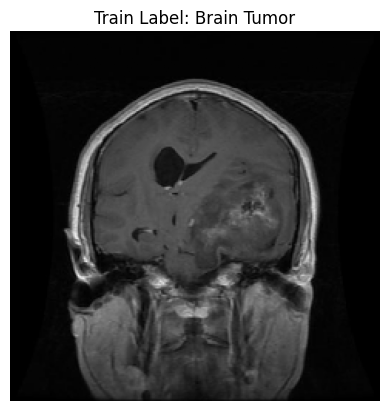

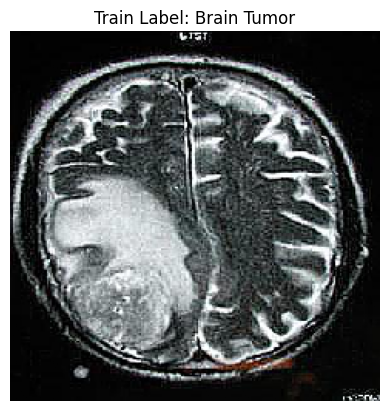

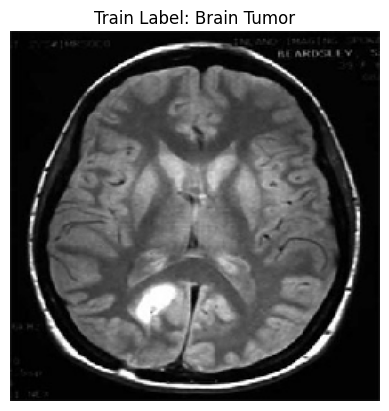

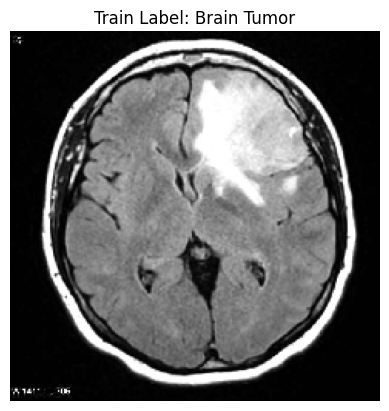

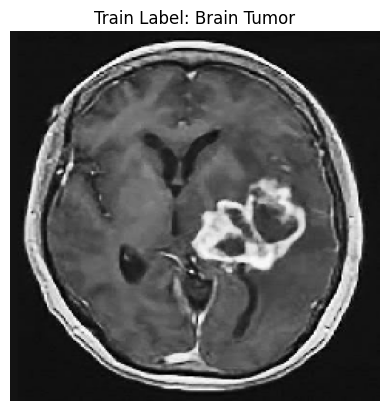

In [42]:
for i in range(5):
    plt.imshow((X_train[i] / 255).astype('float32'))
    label = [key for key, value in labels_brain.items() if value == y_train[i]]
    plt.title(f"Train Label: {label[0]}")
    plt.axis("off")
    plt.show()


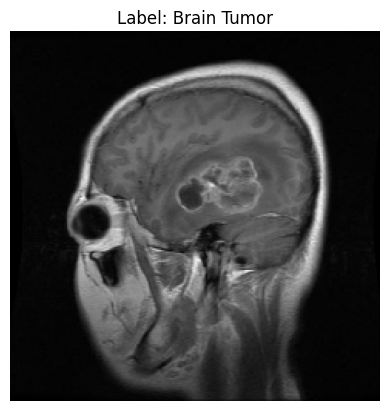

In [41]:

for i in range(20,21):
    plt.imshow((X_train[i] / 255).astype('float32'))
    label = [key for key, value in labels_brain.items() if value == y_data[i]]
    plt.title(f"Label: {label[0]}")
    plt.axis("off")
    plt.show()


------------Train Set------------


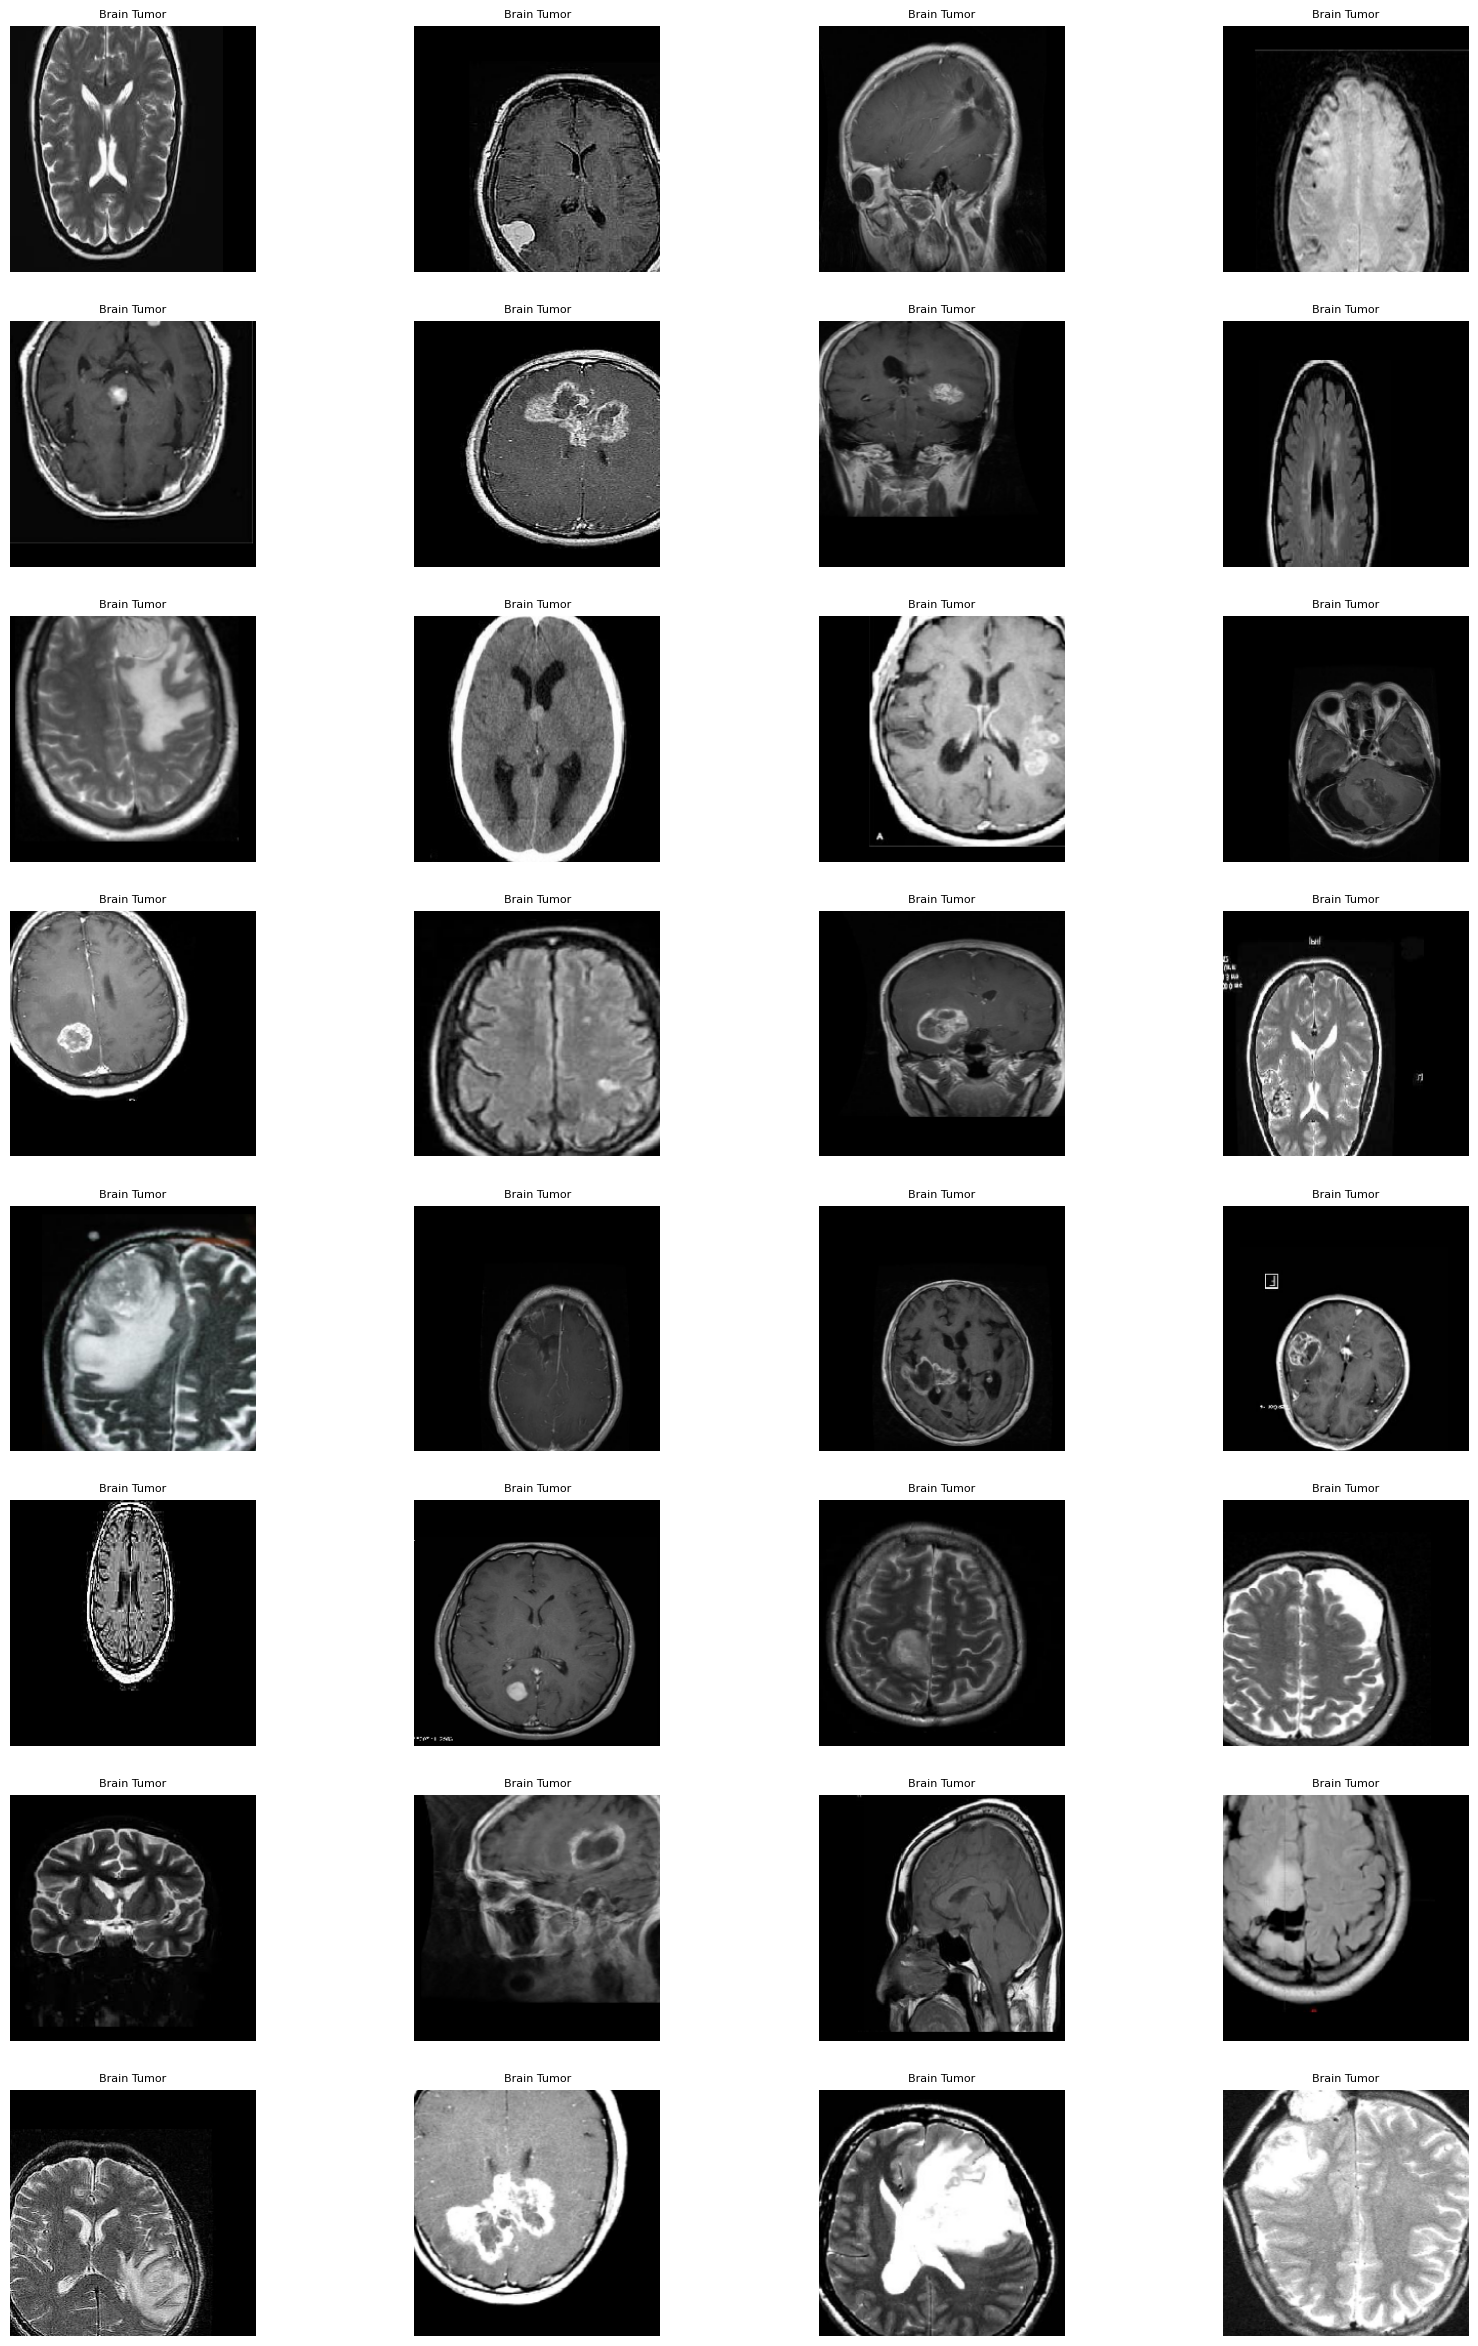

------------Validation Set------------


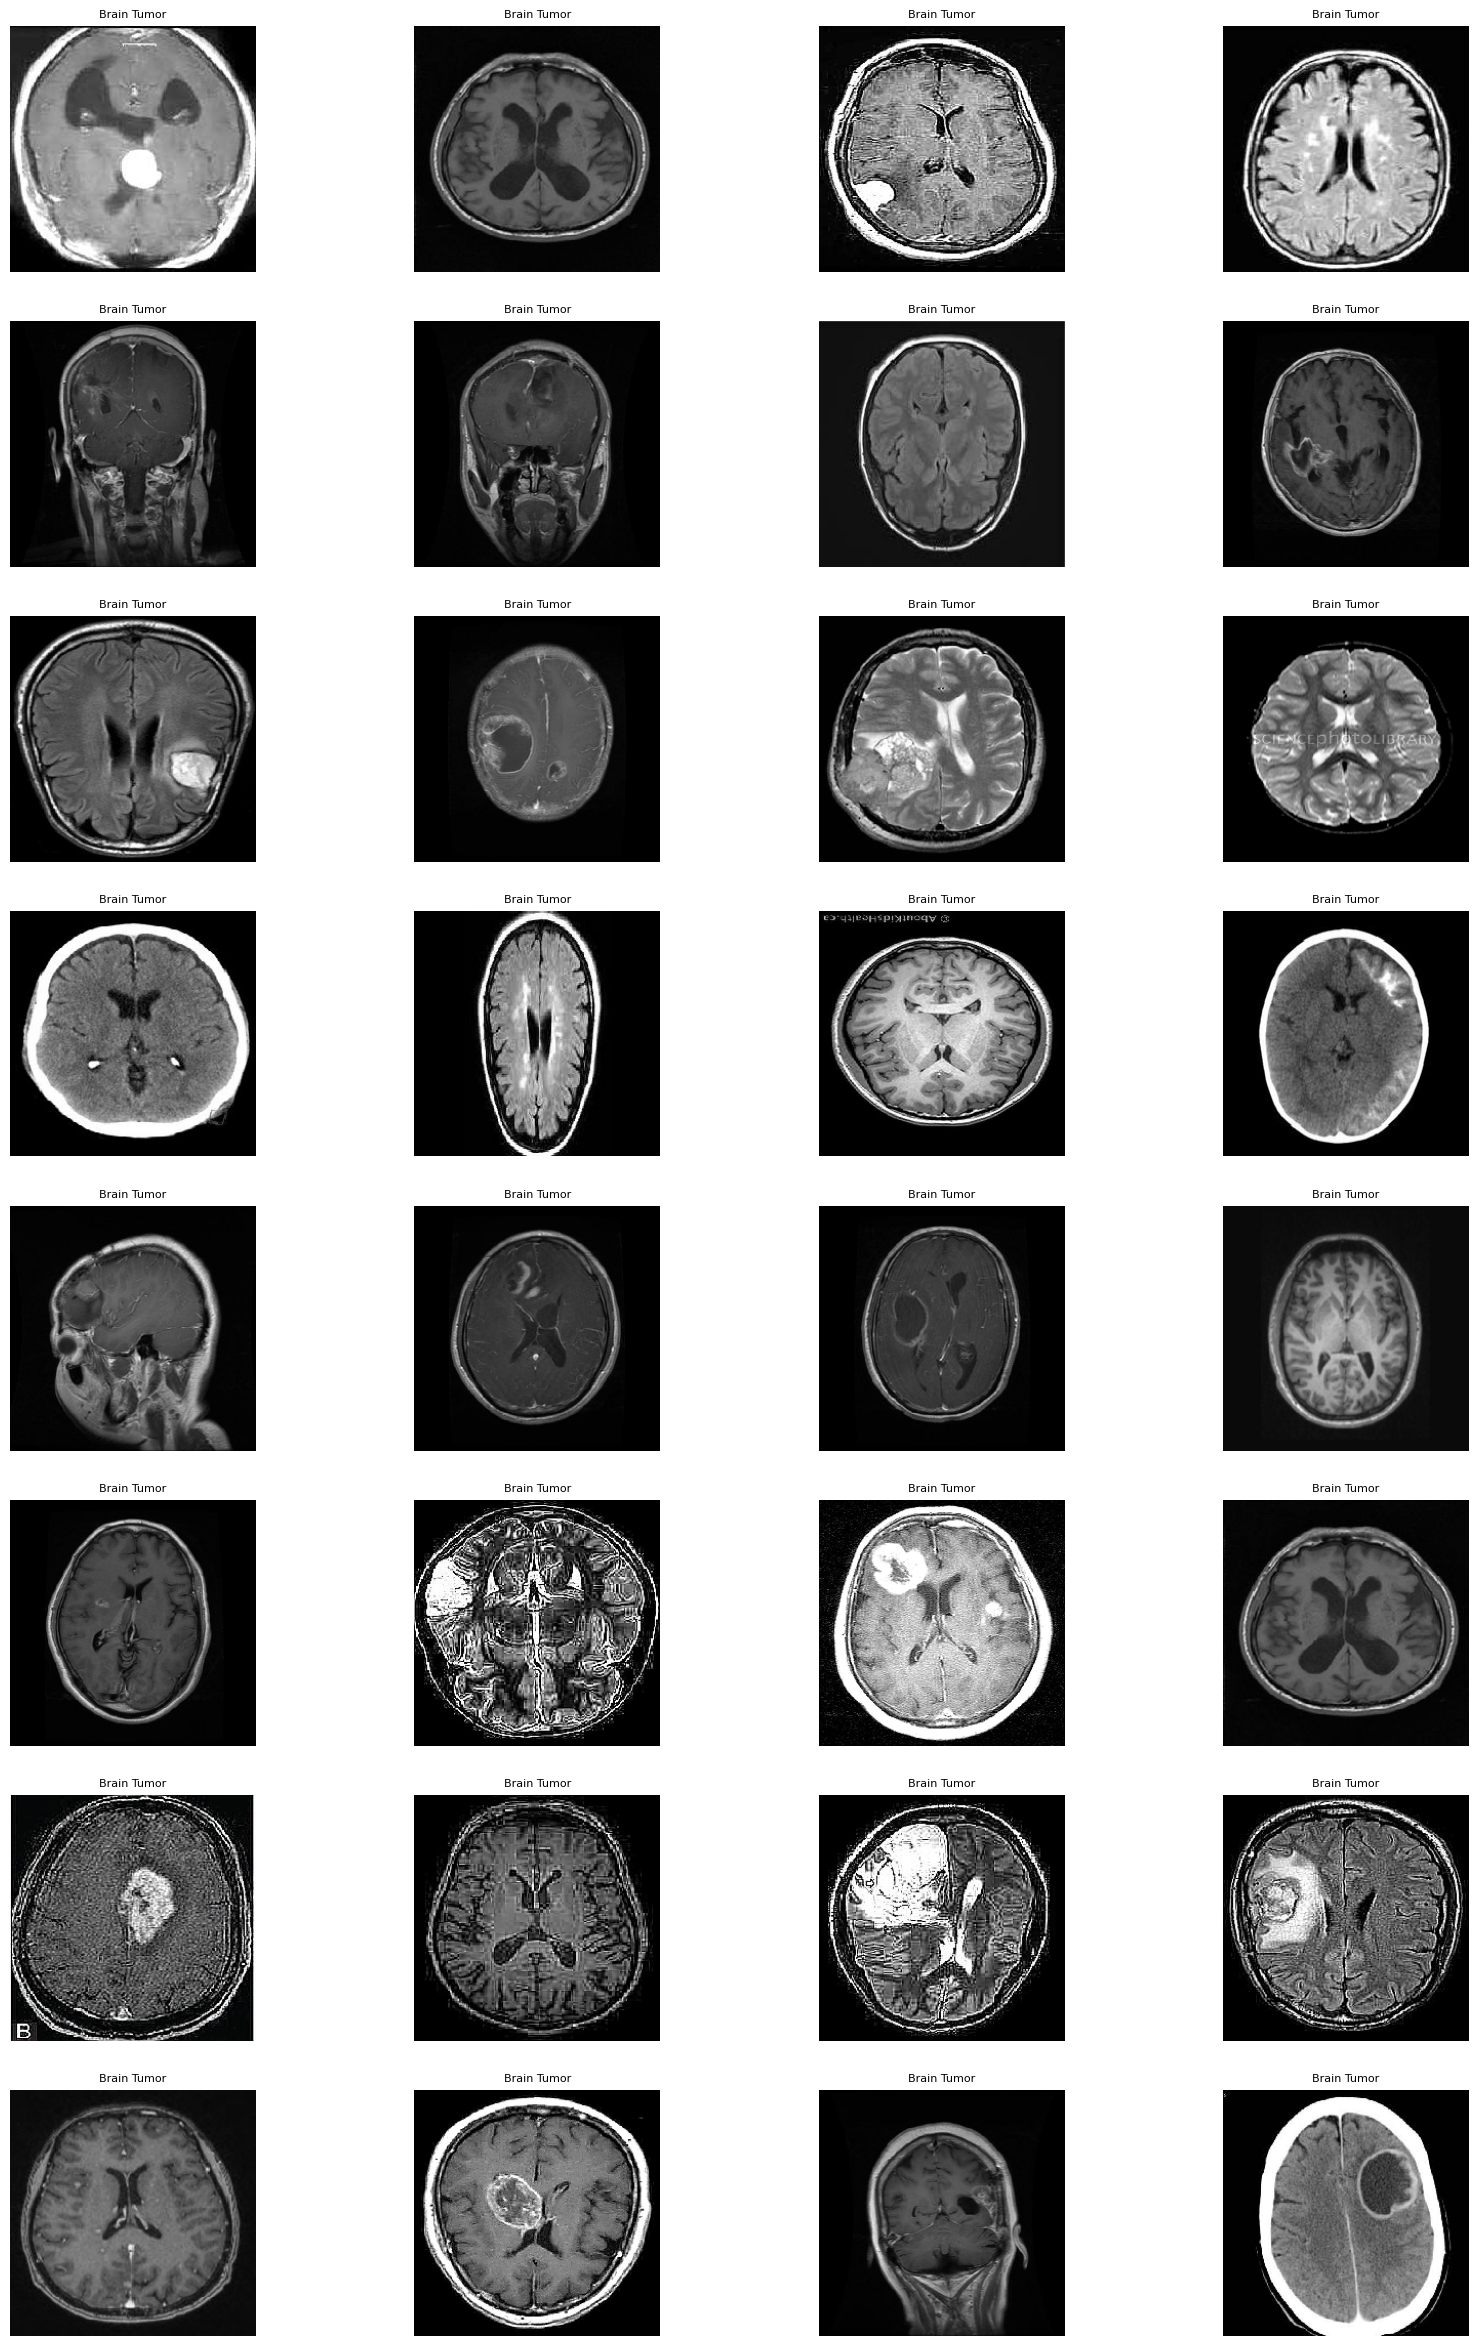

------------Test Set------------


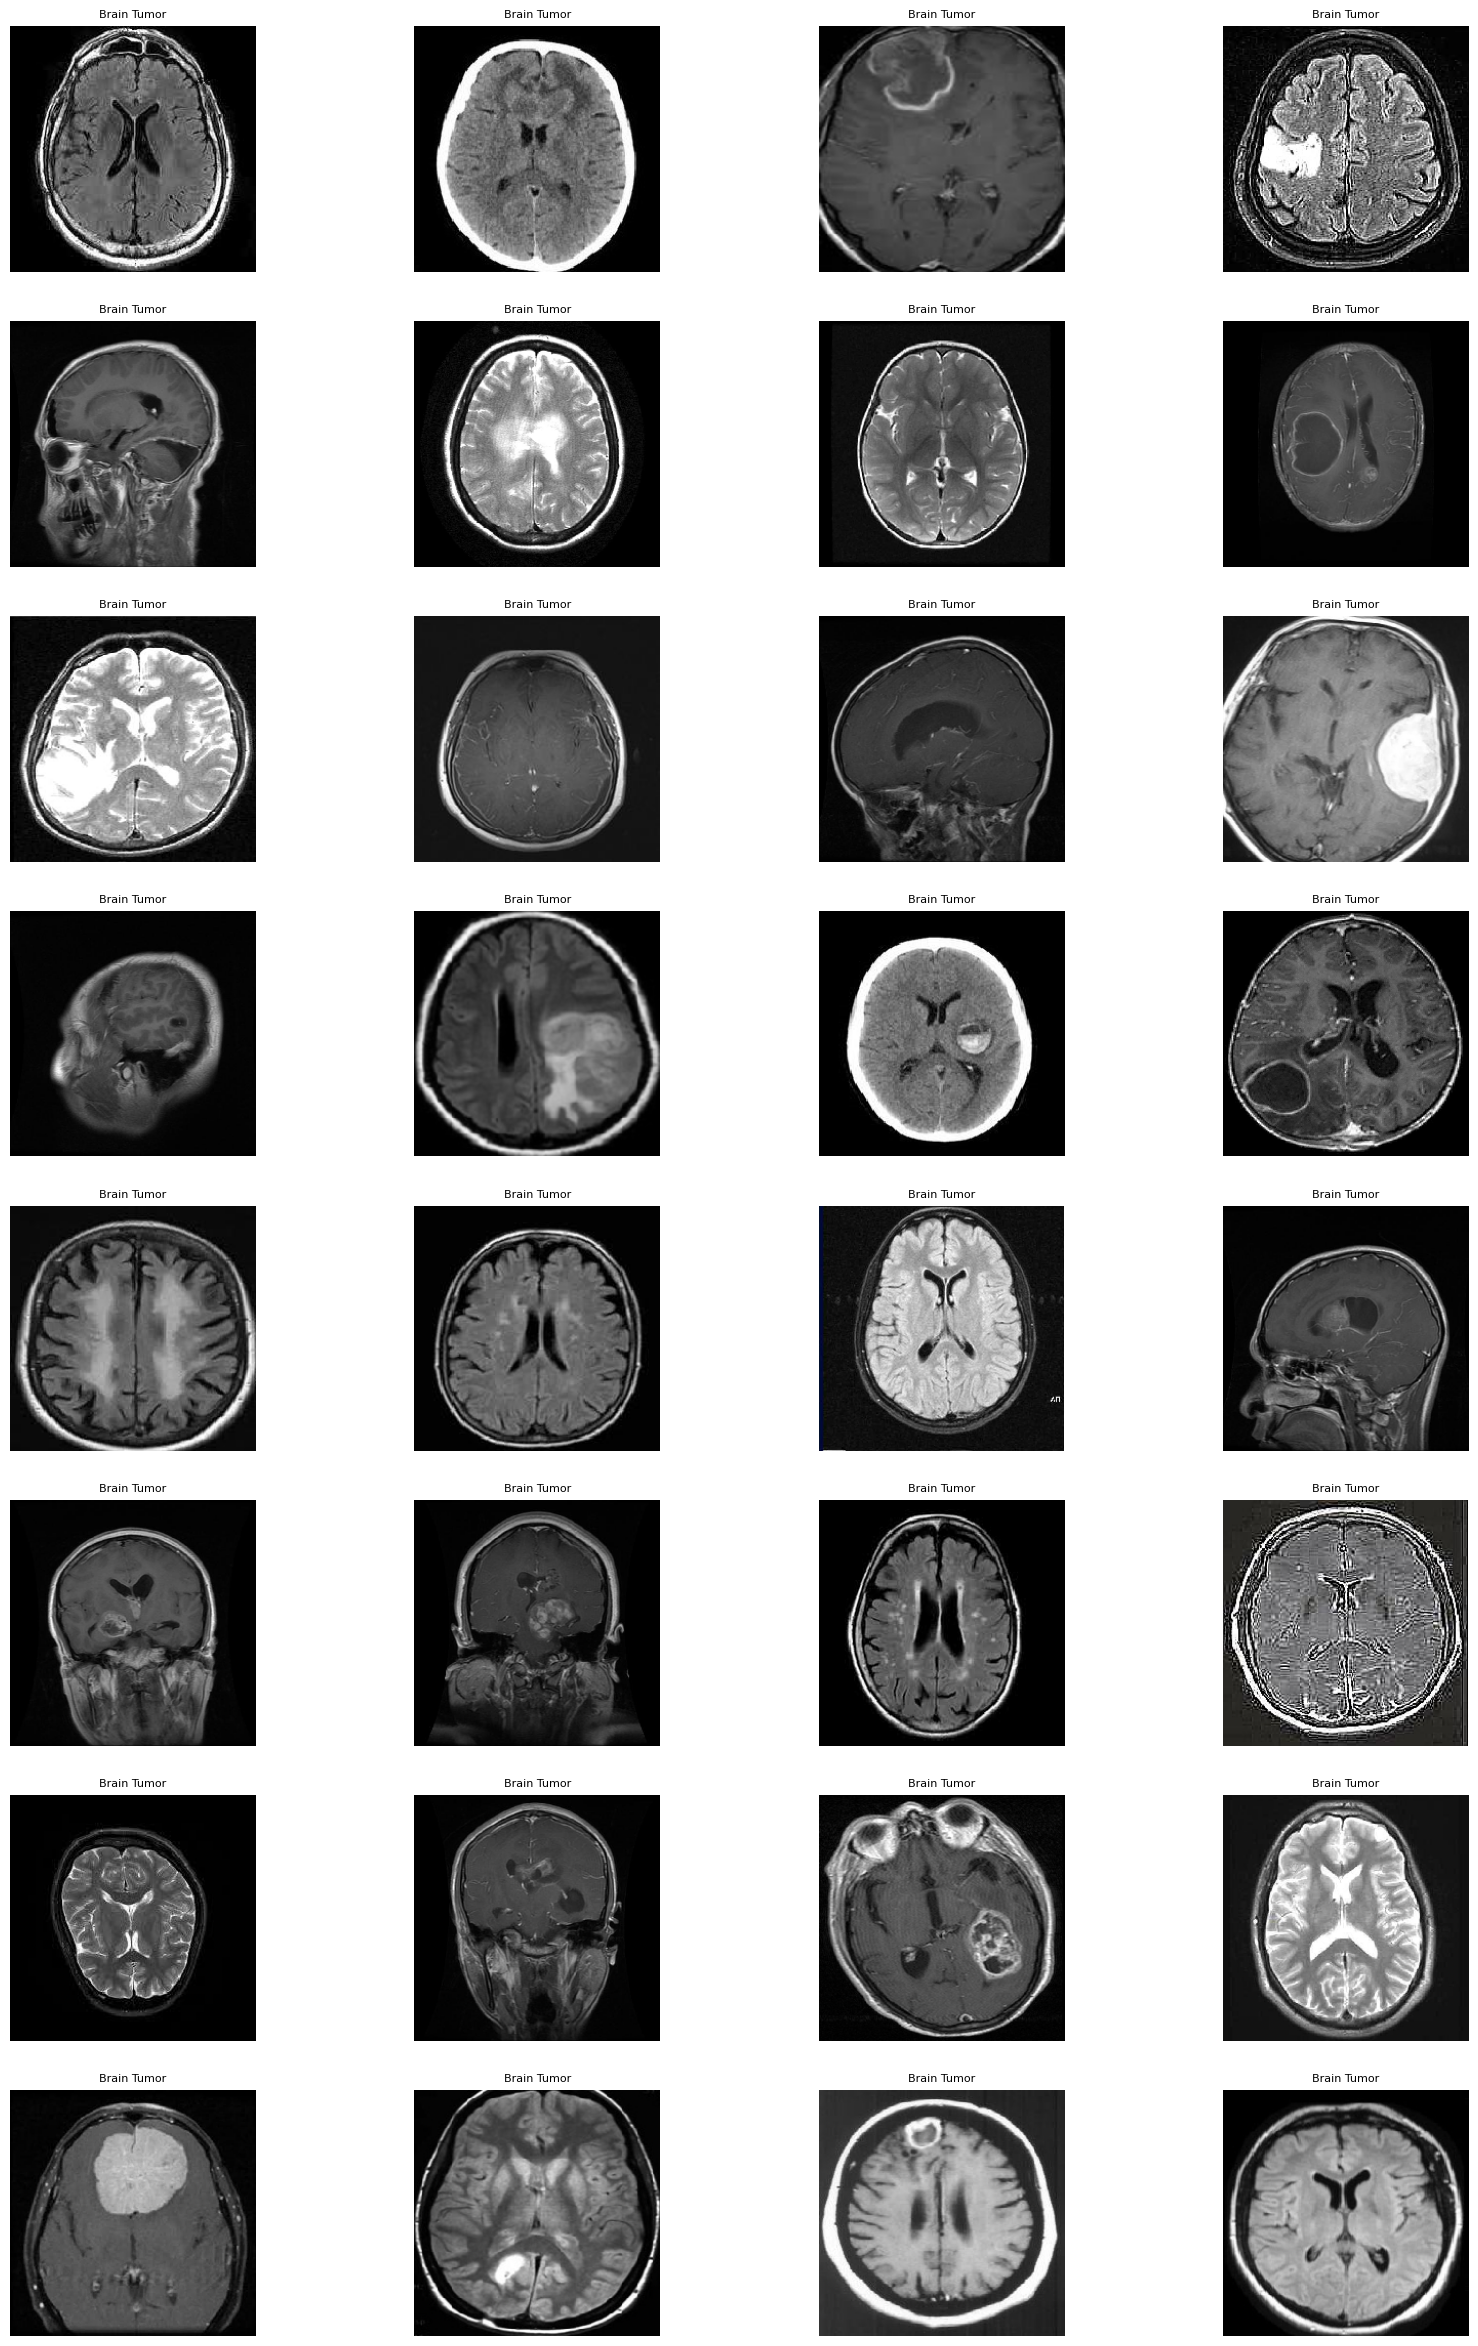

In [20]:
def visualize_image(generator, num_images=100):
    reverse_labels = {v: k for k, v in labels_brain.items()}
    image_batch, label_batch = next(generator)
    
    plt.figure(figsize=(20, 30))
    for n in range(min(num_images, len(image_batch))):
        ax = plt.subplot(8, 4, n + 1)
        
        # rescale to 0-255
        img_rescaled = (image_batch[n] * 255).astype('uint8')
        plt.imshow(img_rescaled)
        
        # Show Labels
        class_index = np.argmax(label_batch[n])
        class_name = reverse_labels[class_index]
        plt.title(class_name, fontsize=8)
        plt.axis("off")
    plt.show()

print("------------Train Set------------")
visualize_image(train_generator, num_images=32)

print("------------Validation Set------------")
visualize_image(val_generator, num_images=32)

print("------------Test Set------------")
visualize_image(test_generator, num_images=32)


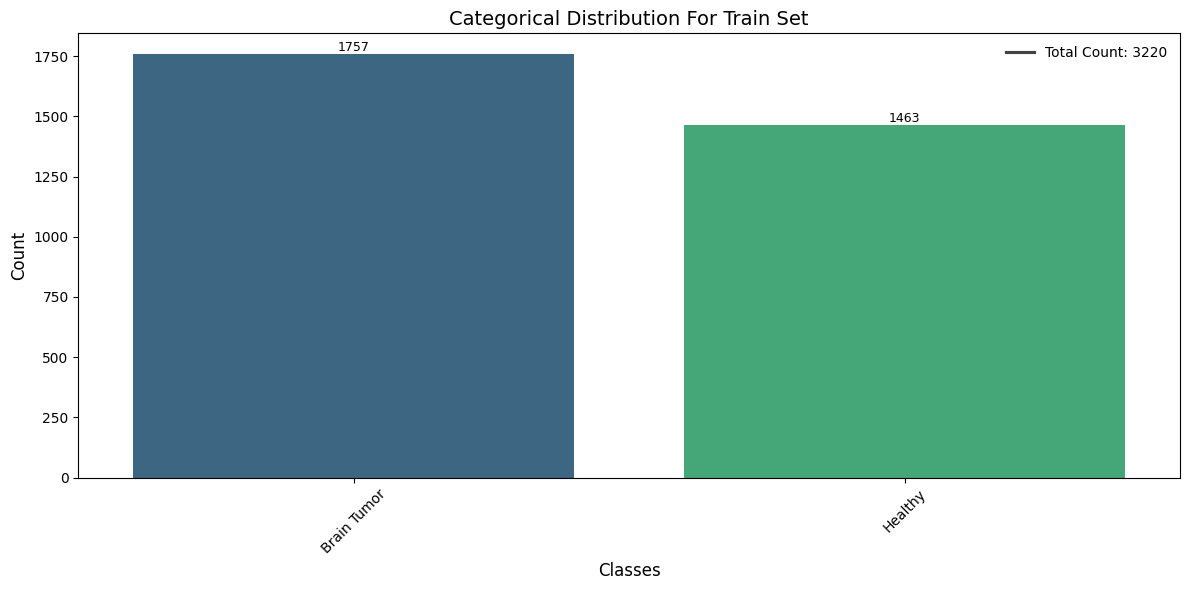

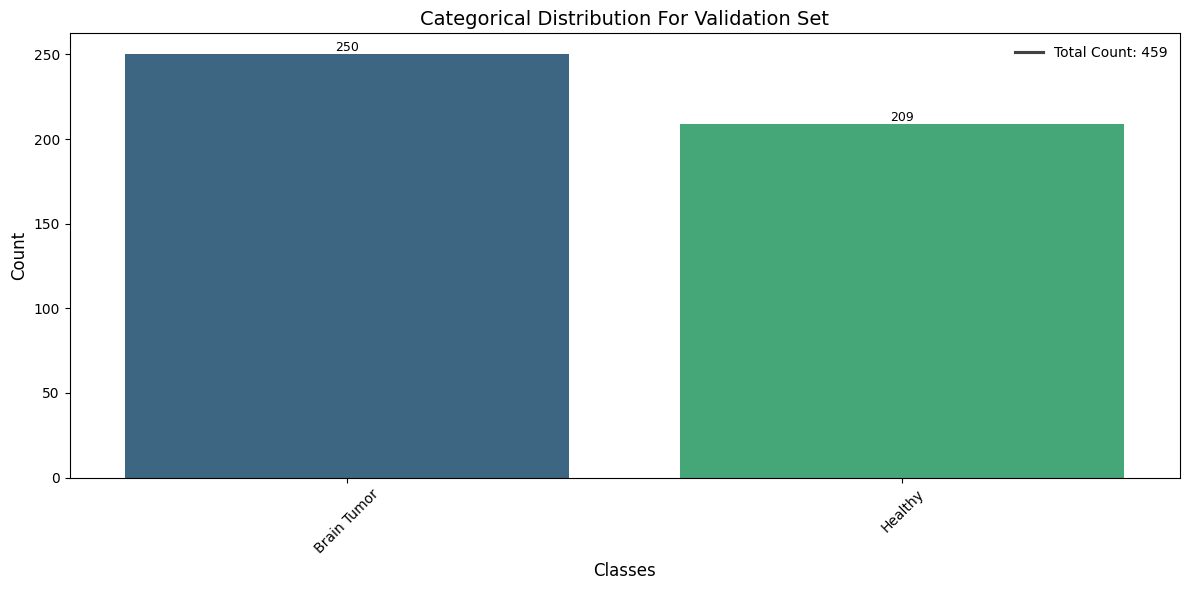

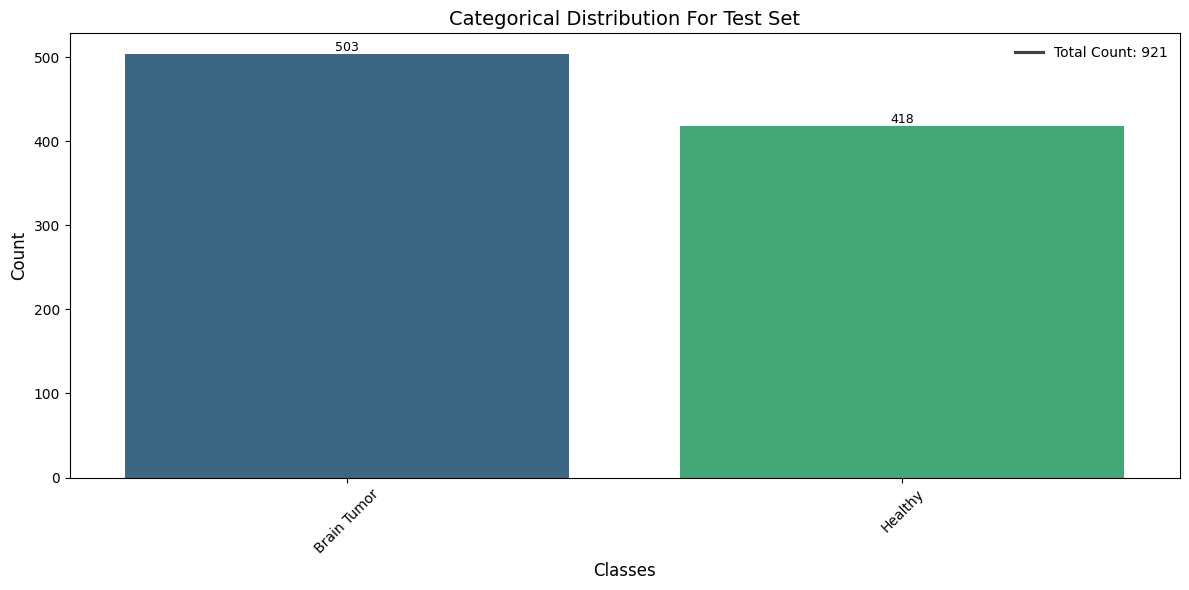

In [19]:
def extract_labels(generator):
    labels = []
    for _ in range(len(generator)):
        _, label_batch = next(generator)
        labels.extend(np.argmax(label_batch, axis=1))
    return labels

def plot_label_distribution(labels, title_name):
    reverse_labels        = {v: k for k, v in labels_brain.items()}
    title                 = "Categorical Distribution For " + title_name
    unique_labels, counts = np.unique(labels, return_counts=True)
    label_names_list      = [reverse_labels[label] for label in unique_labels]

    plt.figure(figsize=(12, 6))
    bars = sns.barplot(x=label_names_list, y=counts, palette="viridis")

    # Quantity
    for bar, count in zip(bars.patches, counts):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f'{count}',
            ha='center',
            va='bottom',
            fontsize=9
        )

    plt.title(title, fontsize=14)
    plt.xlabel("Classes", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45)

    # Legend
    total_count = np.sum(counts)
    plt.legend(
        [f"Total Count: {total_count}"],
        loc="upper right",
        frameon=False,
        fontsize=10
    )

    plt.tight_layout()
    plt.show()

# find labels
train_labels      = extract_labels(train_generator)
validation_labels = extract_labels(val_generator)
test_labels       = extract_labels(test_generator)

plot_label_distribution(train_labels, "Train Set")
plot_label_distribution(validation_labels, "Validation Set")
plot_label_distribution(test_labels, "Test Set")


In [13]:
def plot_pie_chart(labels, title_name):
    reverse_labels = {v: k for k, v in labels_brain.items()}
    unique_labels, counts = np.unique(labels, return_counts=True)
    label_names_list = [reverse_labels[label] for label in unique_labels]

    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=label_names_list, autopct='%1.1f%%', colors=sns.color_palette("viridis", len(counts)))
    plt.title(f"Pie Chart for {title_name}", fontsize=14)
    plt.show()

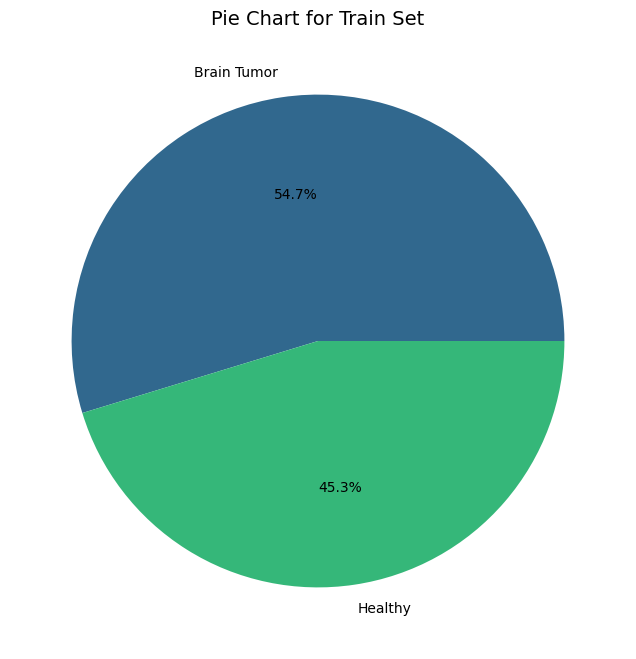

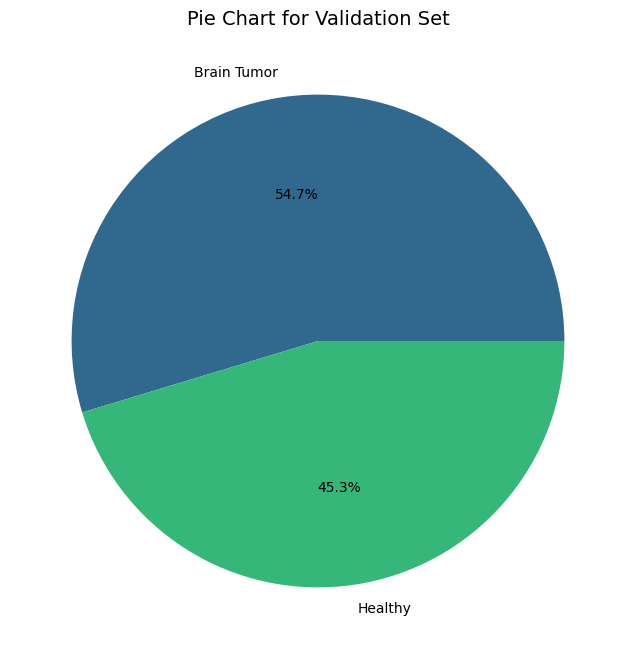

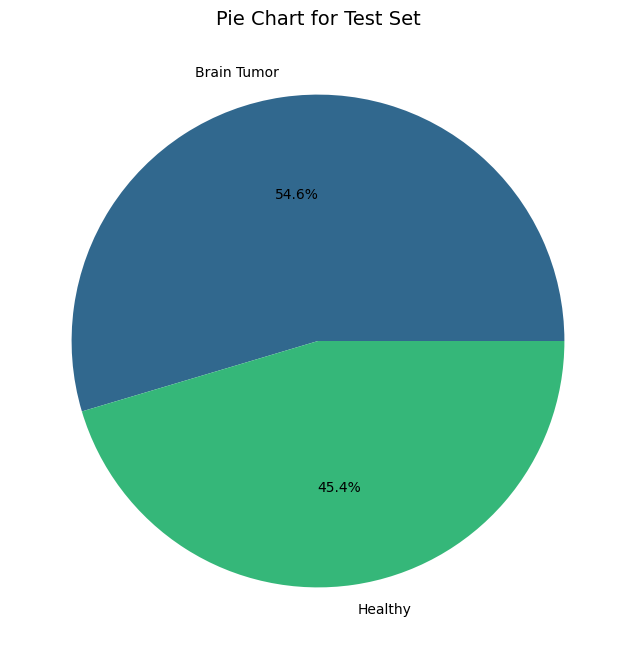

In [14]:
plot_pie_chart(train_labels, "Train Set")
plot_pie_chart(validation_labels, "Validation Set")
plot_pie_chart(test_labels, "Test Set")